# Monte Carlo Algorithms

1. Markov Chains
2. Markov Chain Monte Carlo (MCMC) via Metropolis-Hastings
3. The Wolff algorithm
4. The Wang-Landau algorithm for the density of states
5. The Heatbath algorithm
6. Benchmarking using exact results
7. Comparisons of algorithms using autocorrelation time

## Markov Chains

Some nice visualizations of transition matrices using code from Timothy Budd.

Using the theory of discrete Markov chains coupled with random sampling, one can generate a sequence which simulates a desired probability distribution, $\pi(x)$. There are two central notions:
1. (Perron-Froebenius) Any irreducible, aperiodic transition matrix $K$ has a long time behavior $K^n \approx I\cdot\pi$ where $\pi$ is the stationary distribution. In other words, Eigenval(K)=${\lambda_1,\lambda_2, ...}$ where $\lambda_1=1$ and $\lambda_i<0$ $\forall i>1$. These negative eigenvalues can be understood via relaxational dynamics.
2. Detailed balance implies global balance implies a stationary solution.

The idea for us to simulate a given physical model is then to create an iterative procedure (transition matrix) which given a current state will generate new states. Moreover, this procedure should be irreducible and aperiodic. The last condition of detailed balance ensures that the sequence will converge to the desired distribution. 

See my notes on Markov Chain Monte Carlo Details and The Transition Matrix.

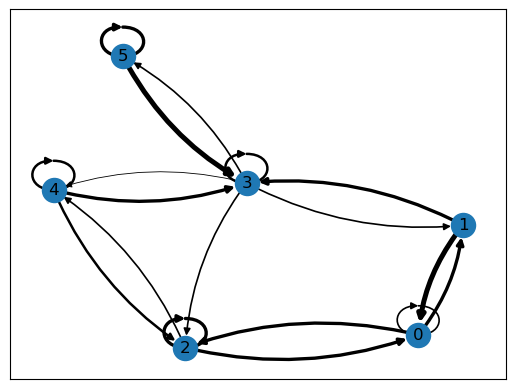

In [2]:
import networkx as nx, numpy as np

num_states = 6
transition_P = np.array([[0.2,0.4,0.4,  0,  0,  0],
                         [0.6,  0,  0,0.4,  0,  0],
                         [0.4,  0,0.4,  0,0.2,  0],
                         [  0,0.2,0.2,0.3,0.1,0.2],
                         [  0,  0,0.3,0.4,0.3,  0],
                         [  0,  0,  0,0.6,  0,0.4]])

def draw_transition_graph(P):
    # construct a directed graph directly from the matrix
    graph = nx.DiGraph(P)        
    # draw it in such a way that edges in both directions are visible and have appropriate width
    nx.draw_networkx(graph,connectionstyle='arc3, rad = 0.15',width=[6*P[u,v] for u,v in graph.edges()])
    
draw_transition_graph(transition_P)

## Markov Chain Monte Carlo via Metropolis-Hastings

The Metropolis-Hastings algorithm generates a Markov chain as follows. Given the state $x$, possible next states $y$ are distributed as $Q(x,y)$. This new state is accepted with probability $\displaystyle \alpha(x,y)=\text{min}(1,\frac{Q(y,x)\pi(y)}{Q(x,y)\pi(x)})$ where $\pi(z)$ is the distribution we wish to simulate. __This Markov chain can be shown to satisfy detailed balance, and thus approach the distribution $\pi(x)$.__ 

Taking $Q(x,y)=Q(y,x)$ simplies the acceptance rate. For simplicity, we will take $Q(x,y)$ to be independent of $x$ and uniform on $y$ - totally "uninformed". Finally, for the Gibbs distribution (Ising model) we have $\alpha=\text{min}\{1,\exp(-\beta \Delta E))\}$. This probabiltiy can be understood by generating a variable $x \sim \text{U}(0,1)$ and accepting the new configuration if $x<\alpha$.

For nearest neighbor interactions, the computation of $\Delta E$ from flipping $s_i$ only requires the nearest neighbor of $s_i$. Roughly, we have the expression $\Delta E = -2 (-J)\, s_i *$ neighbors. To convince yourself, imagine all spins taking $+1$. Flipping a single spin amounts to flipping the signs of the 4 bonds with its neighbors.

# Metropolis algorithm and trace plots

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from time import time

In [ ]:
J = 1 # J can be absorbed into other parameters

In [ ]:
def coldstart(L): 
    ''' LxL Matrix full of aligned spins with s = +1 '''
    return np.ones((L,L)) 

def hotstart(L): 
    ''' LxL Matrix of random spin '''
    return np.random.choice([-1,1],size=(L,L))

def antialigned(L):
    ''' LxL Checkerboard (Using Timothy Budds code - only produces 2d lattice)'''
    if L % 2 == 0:
        return np.tile([[1,-1],[-1,1]],(L//2,L//2))
    else:
        return np.tile([[1,-1],[-1,1]],((L+1)//2,(L+1)//2))[:L,:L]

In [ ]:
def plot_ising(M, ax, title):
    ax.matshow(M,vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
def Metropolis_update(Latt, beta, H, N_iterations ):
    J = 1
    L = len(Latt)
    
    m = np.sum(Latt) # the magnetization
    
    e = 0
    for i in range(L):
        for j in range(L):
            # move through lattice and compute s_i * neighbors
            # this double counts bounds, so divide by 2 afterwards
            e += -J*Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                  + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
    e = e/2 - H*m
    
    trace=np.zeros((N_iterations,2)) # trace of energy and magnetization
    
    for s in range(N_iterations):
        # choose a random spin to flip - convince youself of the dE expression, do it by hand for a small lattice
        i, j = np.random.randint(0, L, 2)
        de = -2 * (-J) * Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                            + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
        de = de + 2*H*Latt[i,j]

        if np.random.rand() < np.exp(-beta*de):
            Latt[i,j] *= -1 # flip the spin if random # < exp(-\beta de)
            e += de
            m += 2*Latt[i,j]
        
        trace[s] = [m,e]
    
    return trace

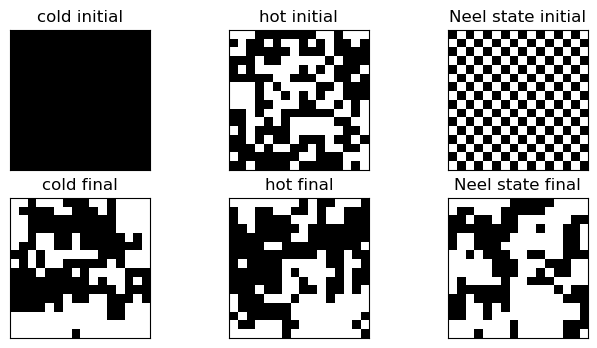

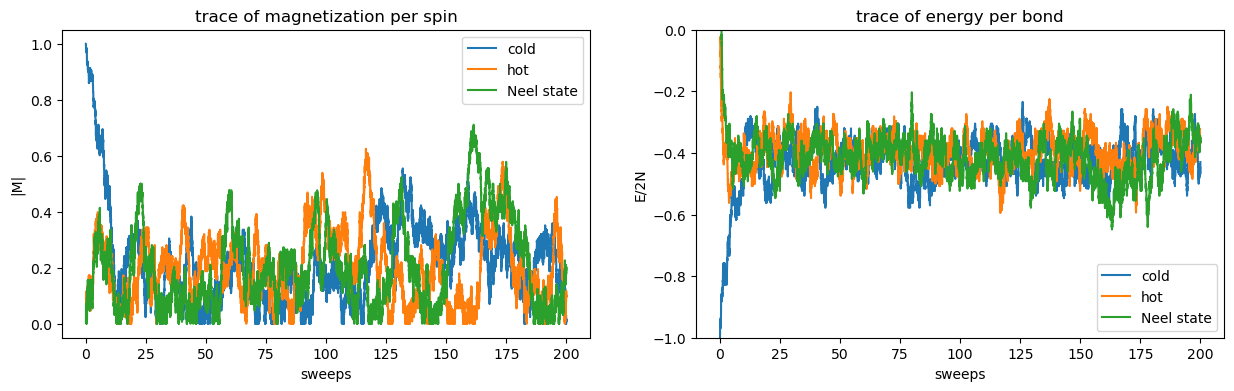

In [ ]:
## Compute a Metropolis update for 200 updates per spin on a 16x16 lattice
## Use a variety of initial conditions to ensure convergence as well as get an idea of equilibriation time
## Code below is adapted from Timothy Budd

L = 16
N_sites = L**2

N_iterations = 200*N_sites

T,H = 3,0
beta = 1/T

initials = [coldstart, hotstart, antialigned]
labels = ["cold", "hot", "Neel state"]
num_ax = len(labels)

# Traces will contain {{e list, m list}, .., } for each initial condition
traces = []

# plot spin lattices for given initial and final configurations
fig, ax = plt.subplots(2, num_ax, figsize=(8,4))

for i, init in enumerate(initials):
    M = init(L)
    
    plot_ising(M,ax[0][i],labels[i]+" initial")
    
    traces.append(Metropolis_update(M, beta, H, N_iterations))
    
    plot_ising(M,ax[1][i],labels[i]+" final")
plt.show()

# plot magnetization and energy traces
fig, ax = plt.subplots(1,2,figsize=(15,4))
xrange = np.arange(N_iterations)/N_sites

for i,init in enumerate(initials):
    ax[0].plot(xrange, np.abs(traces[i][:,0])/N_sites)
    ax[1].plot(xrange, traces[i][:,1]/(2*N_sites))
    
[ ax[s].legend(labels) for s in [0,1] ]
[ ax[s].set_xlabel("sweeps") for s in [0,1] ]
ax[0].set_ylabel("|M|")
ax[1].set_ylabel("E/2N")

ax[1].set_ylim(-1,0)
ax[0].title.set_text("trace of magnetization per spin")
ax[1].title.set_text("trace of energy per bond")

## The Wolff Algorithm

The Wolff algortihm is a single cluster update algorithm. It takes a randon spin, forms a single cluster by joining neighboring spins with $p = 1 -e^{-2\beta J}$, then flips this cluster. There is a nice algorithm for constructing this cluster, apparently named a painting algorithm, which flips every spin as it is put into the cluster, automatically ensuring each spin is visited once.

__Needs:__
1. Write up how to implement for non-zero H. Detailed balance requires cluster is flipped with a probablity...
2. Incorporate efficient energy and magnetization traces

In [ ]:
## Below is code adapted from Timothy Budd - only works for H=0

rng = np.random.default_rng()

def neighboring_sites(s,L):
    '''Return the coordinates of the 4 sites adjacent to s on an LxL lattice.'''
    return [((s[0]+1)%L,s[1]),((s[0]-1)%L,s[1]),(s[0],(s[1]+1)%L),(s[0],(s[1]-1)%L)]

def Wolff_update(Latt, beta, H, N_iterations ):
    J = 1
    L = len(Latt)
    p_add = 1 - np.exp(-2*beta)
    
    trace = np.zeros((N_iterations,2)) # trace of energy and magnetization
    
## Below is code for non-zero H $$

#     for s in range(N_iterations):
#         i, j = np.random.randint(0, L, 2)
#         proposal = Latt.copy()
#         seed = tuple([i,j])
#         spin = proposal[seed]
#         proposal[seed] = -spin
#         cluster_size = 1
#         unvisited = [seed]
#         while unvisited:
#             site = unvisited.pop()
#             for nbr in neighboring_sites(site,L):
#                 if proposal[nbr] == spin and rng.uniform() < p_add:
#                     proposal[nbr] = -spin
#                     unvisited.append(nbr)
#                     cluster_size += 1
        
#         de_h = 2*H*cluster_size
        
#         if np.random.rand() < min(1, np.exp(-beta * de_h )):
#             Latt = proposal

## The computation of energy and magnetization traces needs to be improved 

    for s in range(N_iterations):
        i, j = np.random.randint(0, L, 2)
        seed = tuple([i,j])
        spin = Latt[seed]
        Latt[seed] = -spin
        cluster_size = 1
        unvisited = [seed]
        while unvisited:
            site = unvisited.pop()
            for nbr in neighboring_sites(site,L):
                if Latt[nbr] == spin and rng.uniform() < p_add:
                    Latt[nbr] = -spin
                    unvisited.append(nbr)
                    cluster_size += 1
            
        m = np.sum(Latt) # the magnetization
        
        e = 0
        for i in range(L):
            for j in range(L):
                e += -J*Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                      + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
        e = e/2 - H*m
        
        trace[s] = [m,e]
        
        #print(Latt - coldstart(L))
        #print(Latt)
        #print(proposal)
    
    return trace

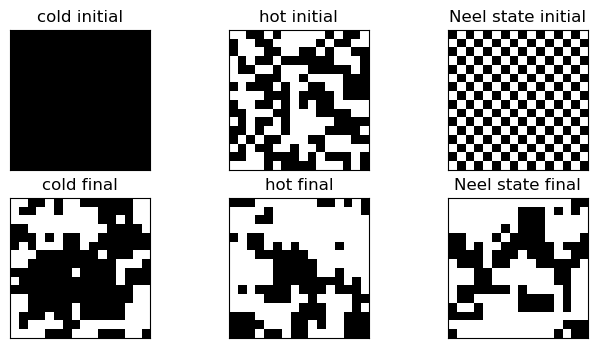

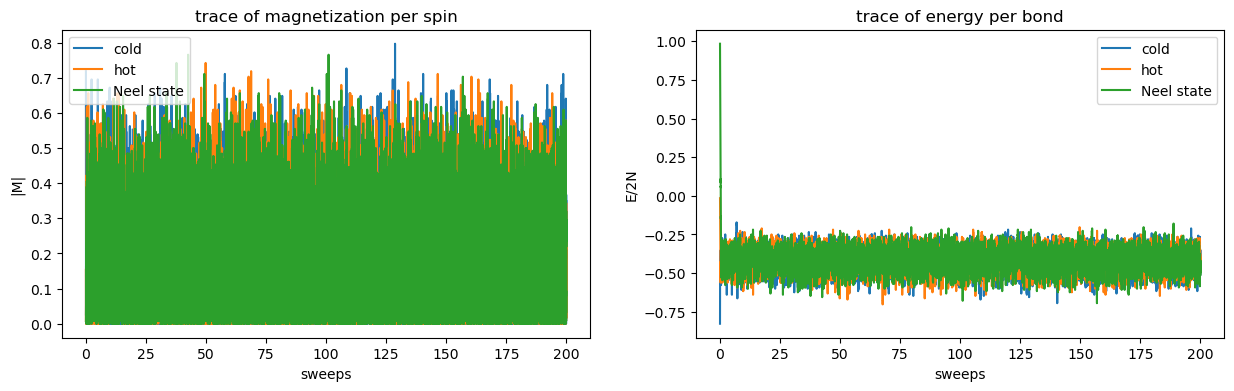

In [ ]:
## Compute a Wolff update for 200 updates per spin on a 16x16 lattice
## Use a variety of initial conditions to ensure convergence as well as get an idea of equilibriation time
## Code below is adapted from Timothy Budd

L = 16
N_sites = L**2

N_iterations = 200*N_sites

T,H = 3,0
beta = 1/T

initials = [coldstart, hotstart, antialigned]
labels = ["cold", "hot", "Neel state"]
num_ax = len(labels)

# Traces will contain {{e list, m list}, .., } for each initial condition
traces = []

# plot spin lattices for given initial and final configurations
fig, ax = plt.subplots(2, num_ax, figsize=(8,4))

for i, init in enumerate(initials):
    M = init(L)
    
    plot_ising(M, ax[0][i], labels[i]+" initial")
    
    traces.append(Wolff_update(M, beta, H, N_iterations))
    
    plot_ising(M, ax[1][i], labels[i]+" final")
plt.show()

# plot magnetization and energy traces
fig, ax = plt.subplots(1,2,figsize=(15,4))
xrange = np.arange(N_iterations)/N_sites

for i,init in enumerate(initials):
    ax[0].plot(xrange, np.abs(traces[i][:,0])/N_sites)
    ax[1].plot(xrange, traces[i][:,1]/(2*N_sites))
    
[ ax[s].legend(labels) for s in [0,1] ]
[ ax[s].set_xlabel("sweeps") for s in [0,1] ]
ax[0].set_ylabel("|M|")
ax[1].set_ylabel("E/2N")

# ax[1].set_ylim(-1,0)
ax[0].title.set_text("trace of magnetization per spin")
ax[1].title.set_text("trace of energy per bond")

In [ ]:
def cluster_flip(state,seed,p_add):
    L = len(state)
    spin = state[seed]
    state[seed] = -spin
    cluster_size = 1
    unvisited = [seed]
    while unvisited:
        site = unvisited.pop()
        for nbr in neighboring_sites(site,L):
            if state[nbr] == spin and rng.uniform() < p_add:
                state[nbr] = -spin
                unvisited.append(nbr)
                cluster_size += 1
    return cluster_size
                
def wolff_cluster_move(state, p_add):
    L = len(state)
    seed = tuple(rng.integers(0, L, 2))
    return cluster_flip(state,seed,p_add)

def wolff_update(state, p_add):
    L = len(state)
    seed = tuple(rng.integers(0, L, 2))
    return cluster_flip(state,seed,p_add)

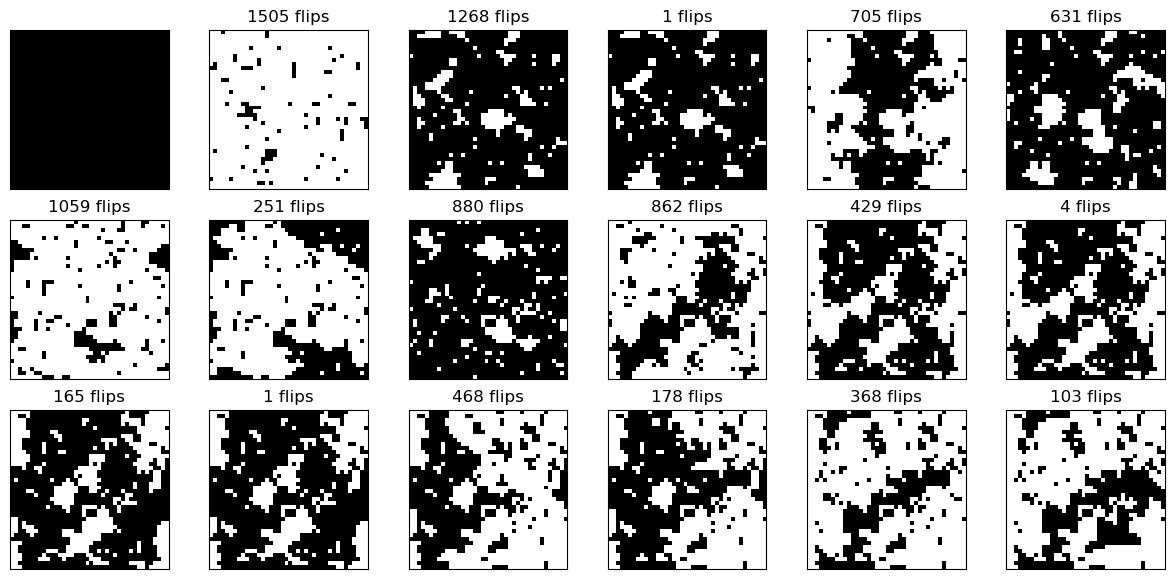

In [ ]:
L = 40
temperature = 2.4
p_add = 1 - np.exp(-2/temperature)
config = coldstart(L)
fig, axs = plt.subplots(3,6,figsize=(15,7))
flips = 0
for axrow in axs:
    for ax in axrow:
        plot_ising(config,ax,"{} flips".format(flips) if flips > 0 else "")
        flips = wolff_cluster_move(config,p_add)

In [ ]:
def compute_magnetization(config):
    '''Compute the magnetization M(s) of the state config.'''
    return np.sum(config)

def run_ising_wolff_mcmc(state,p_add,n):
    '''Run n Wolff moves on state and return total number of spins flipped.'''
    total = 0
    for _ in range(n):
        total += wolff_cluster_move(state,p_add)
    return total

def sample_autocovariance(x,tmax):
    '''Compute the autocorrelation of the time series x for t = 0,1,...,tmax-1.'''
    x_shifted = x - np.mean(x)
    return np.array([np.dot(x_shifted[:len(x)-t],x_shifted[t:])/len(x) 
                     for t in range(tmax)])

def find_correlation_time(autocov):
    '''Return the index of the first entry that is smaller than 
    autocov[0]/e or the length of autocov if none are smaller.'''
    smaller = np.where(autocov < np.exp(-1)*autocov[0])[0]
    return smaller[0] if len(smaller) > 0 else len(autocov)

width = 20
nsites = width*width
temperatures = np.linspace(1.5,3.5,13)
equil_moves = 200
autocorr_moves = 2400
tmax = 70

autocorr_times = []

for temp in temperatures:
    p_add = 1 - np.exp(-2/temp)
    state = coldstart(width)
    run_ising_wolff_mcmc(state,p_add,equil_moves)
    total_flips = 0
    trace = np.zeros(autocorr_moves)
    for i in range(autocorr_moves):
        total_flips += run_ising_wolff_mcmc(state,p_add,1)
        trace[i] = compute_magnetization(state)
    autocov = sample_autocovariance(np.abs(trace),tmax)
    time = find_correlation_time(autocov)
    autocorr_times.append((time,total_flips/(autocorr_moves)))

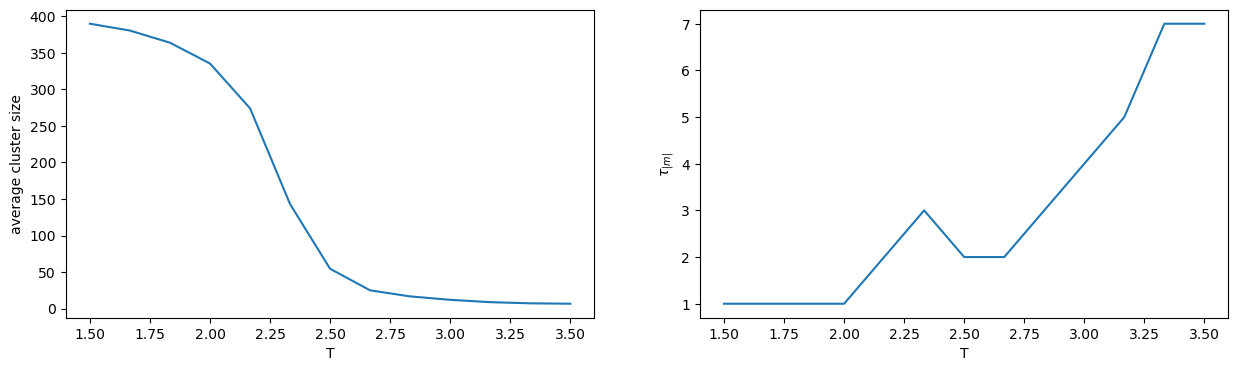

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(temperatures,[av_size for tau,av_size in autocorr_times])
ax[0].set_xlabel("T")
ax[0].set_ylabel("average cluster size")
ax[1].plot(temperatures,[tau for tau,av_size in autocorr_times])
ax[1].set_xlabel("T")
ax[1].set_ylabel(r"$\tau_{|m|}$")
plt.show()

# The Heatbath Algorithm

Instead of flipping a spin based off the change in energy, flip it based off a thermal equiblibrium distribution. Given that $\text{Prob}(s_i=+1) \propto e^{-\beta E_{i,+}}$:
$$\text{Prob}(s_i=+1) =\frac{e^{-\beta E_{i,+}}}{e^{-\beta E_{i,+}}+e^{-\beta E_{i,-}}}$$
The local energies for the spin at site $i$ are given by
$$E_{i,+} = -J s_i \sum neighbors = -J \sum neighbors$$
$$E_{i,-} = J \sum neighbors$$
Then we have that 
$$ \text{Prob}(s_i=+1) =\frac{1}{1+e^{-2\beta \sum neighbors}} $$
$$ \text{Prob}(s_i=-1) =\frac{1}{1+e^{\, 2\beta \sum neighbors}} $$
or for non-zero external fields
$$ \text{Prob}(s_i=+1) =\frac{1}{1+e^{-2\beta (\sum neighbors+H)}} $$
$$ \text{Prob}(s_i=-1) =\frac{1}{1+e^{\,2\beta (\sum neighbors+H)}} $$

Since if the spin is $+1$, then $\Delta E = 2*\sum neighbors$; however, if the spin is $-1$, then $\Delta E = -2*\sum neighbors$. So if spin is up, we flip with probablity $(1+e^{\beta \Delta E})^{-1}$. And if spin is down, we flip with probablity $(1+e^{\beta \Delta E})^{-1}$.

Ultimately, we have 
$$\text{Prob}(flip) =\frac{1}{1+e^{\beta \Delta E}} $$

In [ ]:
def Heatbath_update(Latt, beta, H, N_iterations ):
    J = 1
    L = len(Latt)
    
    m = np.sum(Latt) # the magnetization
    
    e = 0
    for i in range(L):
        for j in range(L):
            # move through lattice and compute s_i * neighbors
            # this double counts bounds, so divide by 2 afterwards
            e += -J*Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                  + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
    e = e/2 - H*m
    
    trace=np.zeros((N_iterations,2)) # trace of energy and magnetization
    
    for s in range(N_iterations):
        # choose a random spin to flip - convince youself of the dE expression, do it by hand for a small lattice
        i, j = np.random.randint(0, L, 2)
        de = -2 * (-J) * Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                            + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
        de = de + 2*H*Latt[i,j]

        if np.random.rand() < 1/(1+np.exp(beta*de)):
            Latt[i,j] *= -1 # flip spin and increment energy and magnetization
            e += de
            m += 2*Latt[i,j]
        
        trace[s] = [m,e]
    
    return trace

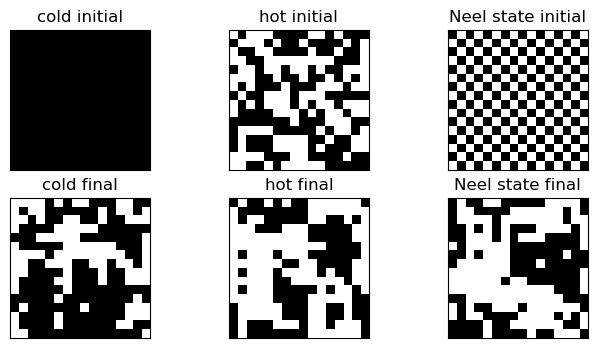

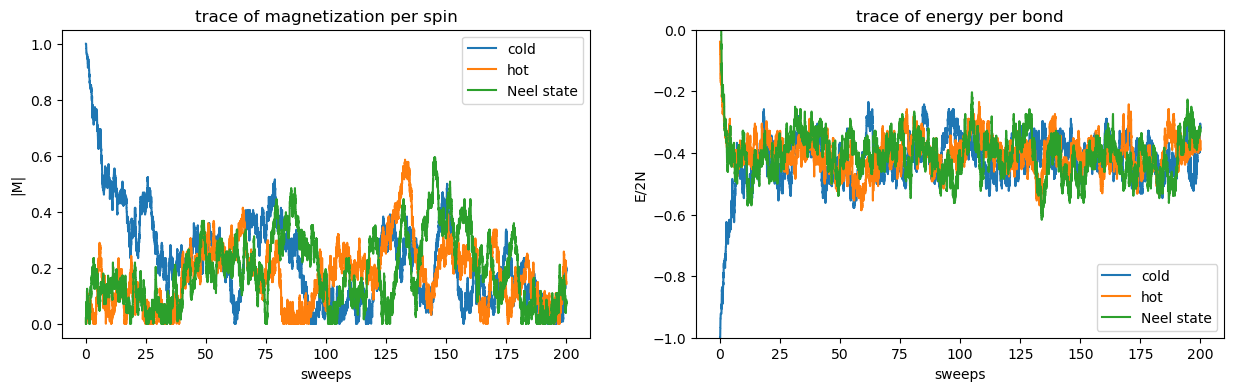

In [ ]:
## Compute a Heatbath update for 200 updates per spin on a 16x16 lattice
## Use a variety of initial conditions to ensure convergence as well as get an idea of equilibriation time
## Code below is adapted from Timothy Budd

L = 16
N_sites = L**2

N_iterations = 200*N_sites

T,H = 3,0
beta = 1/T

initials = [coldstart, hotstart, antialigned]
labels = ["cold", "hot", "Neel state"]
num_ax = len(labels)

# Traces will contain {{e list, m list}, .., } for each initial condition
traces = []

# plot spin lattices for given initial and final configurations
fig, ax = plt.subplots(2, num_ax, figsize=(8,4))

for i, init in enumerate(initials):
    M = init(L)
    
    plot_ising(M,ax[0][i],labels[i]+" initial")
    
    traces.append(Heatbath_update(M, beta, H, N_iterations))
    
    plot_ising(M,ax[1][i],labels[i]+" final")
plt.show()

# plot magnetization and energy traces
fig, ax = plt.subplots(1,2,figsize=(15,4))
xrange = np.arange(N_iterations)/N_sites

for i,init in enumerate(initials):
    ax[0].plot(xrange, np.abs(traces[i][:,0])/N_sites)
    ax[1].plot(xrange, traces[i][:,1]/(2*N_sites))
    
[ ax[s].legend(labels) for s in [0,1] ]
[ ax[s].set_xlabel("sweeps") for s in [0,1] ]
ax[0].set_ylabel("|M|")
ax[1].set_ylabel("E/2N")

ax[1].set_ylim(-1,0)
ax[0].title.set_text("trace of magnetization per spin")
ax[1].title.set_text("trace of energy per bond")

# The Wang-Landau Algorithm for the denisty of states

__Rough Sketch:__
A non-Markovian process to generate the density of states for systems with a finite number of discrete energy levels. This is a random walk in energy space.
- To begin, initialize $g(E_i) = 1 $ and $h(E_i)=0$  $\forall i$ and take the lattice to be, say, aligned. Set $f = e^1$
    1. Current energy is $E_i$. Choose a random spin and deteremine and compute the energy change, so $E_j=E_i+\Delta E$.
    2. Accept new state with probablity $\alpha = \text{min}(1, \, \frac{g(E_i)}{g(E_j)} )$.
    3. If accepted, $g(E_j) \to  f \times g(E_i)$ and $h(E_i)=h(E_i)+ 1$
    4. Repeated procedure until, say 20% flatness, min$(h(E))> 0.8$ mean$(h(E))$ and max$(h(E))< 1.2$ mean$(h(E))$.
        - If flat, take $f \to f^{1/2}$ ( or other reduction ), reset the histrogram to 0s, and return to step one.
            - Do not change the denisty of states!
        - If $f < f_{min} = 1+10^{-8}$, terminate procedure. ( f_min can be altered as well.)
- In practice, use the log density of states.
- Return the relative density of states. Use known results to normalize the density of states. For instance, $g(E = -2NJ)=2.$

In [ ]:
def E_list_gen(L):
    ''' Generates list of energies for even L '''
    if L % 2 != 0:
        raise ValueError("This list generation only works for even side lengths")
        
    E_list=[-2*L**2 + 4*k for k in range(0,L**2+1)]
    E_list.pop(1)
    E_list.pop(-2)
    E_list=np.array(E_list)  # energy states = N-1 
    
    # Emax = 2*L**2
    # [(e+Emax)//4 for e in E_list]
    
    return E_list

In [ ]:
def Wang_Landau_update(L, N_sweeps = 10**3, flatness = .2, logf = 1, fmod = 1/2, f_criteria = 1e-8):
    # Initialize using fully aligned state
    E_list = E_list_gen(L)
    lngE_list = np.zeros_like(E_list, dtype = float)
    hE_list = np.zeros_like(E_list, dtype = int)
    state = coldstart(L)
    e1 = -2*L**2
    index1 = np.argwhere( E_list == e1)[0,0]

    while logf > f_criteria:
        # reset the histogram each iteration
        hE_list.fill(0)
        iteration = 0
        # run while loop while not(h_min < .8 h_mean and h_max > 1.2 h_mean)
        while np.min(hE_list) <= (1-flatness)*np.mean(hE_list) or np.max(hE_list) >= (1+flatness)*np.mean(hE_list):
            for s in range(N_sweeps*L**2):                
                i,j = rng.integers(0, L, 2)
                de = 2*state[i,j]*( state[i, (j+1)%L] + state[i, (j-1)%L] + 
                                   state[(i+1)%L, j] + state[ (i-1)%L, j] )
                e2 = e1 + de
                index2 = np.argwhere( E_list == e2)[0,0]
                
                if np.random.random() < np.exp(lngE_list[index1]-lngE_list[index2]):
                    state[i,j] *= -1
                    e1 = e2
                    index1 = index2
                else:
                    index1 = index1
                    
                lngE_list[index1] += logf
                hE_list[index1] += 1 
                iteration += 1
                
        print(" log(f) = ", logf, " and sweeps =", iteration//L**2)
        logf *= 1/2

    return lngE_list, hE_list

In [ ]:
t0 = time()
L = 8
lngE_list, hE_list = Wang_Landau_update(L = L)
print("Computation time = ", time()-t0)

 log(f) =  1  and sweeps = 1000
 log(f) =  0.5  and sweeps = 1000
 log(f) =  0.25  and sweeps = 3000
 log(f) =  0.125  and sweeps = 2000
 log(f) =  0.0625  and sweeps = 3000
 log(f) =  0.03125  and sweeps = 2000
 log(f) =  0.015625  and sweeps = 2000
 log(f) =  0.0078125  and sweeps = 3000
 log(f) =  0.00390625  and sweeps = 4000
 log(f) =  0.001953125  and sweeps = 4000
 log(f) =  0.0009765625  and sweeps = 5000
 log(f) =  0.00048828125  and sweeps = 9000
 log(f) =  0.000244140625  and sweeps = 4000
 log(f) =  0.0001220703125  and sweeps = 11000
 log(f) =  6.103515625e-05  and sweeps = 27000
 log(f) =  3.0517578125e-05  and sweeps = 5000
 log(f) =  1.52587890625e-05  and sweeps = 11000
 log(f) =  7.62939453125e-06  and sweeps = 15000
 log(f) =  3.814697265625e-06  and sweeps = 35000
 log(f) =  1.9073486328125e-06  and sweeps = 12000
 log(f) =  9.5367431640625e-07  and sweeps = 7000
 log(f) =  4.76837158203125e-07  and sweeps = 8000
 log(f) =  2.384185791015625e-07  and sweeps = 45000


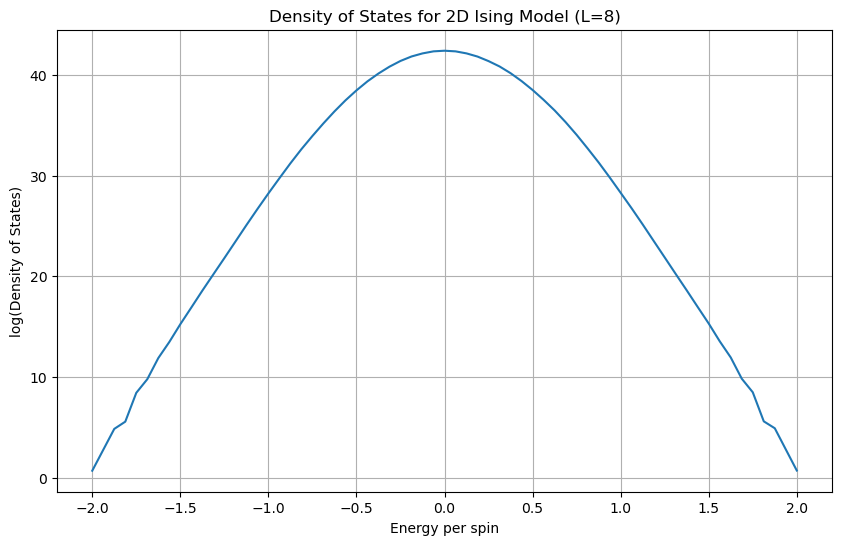

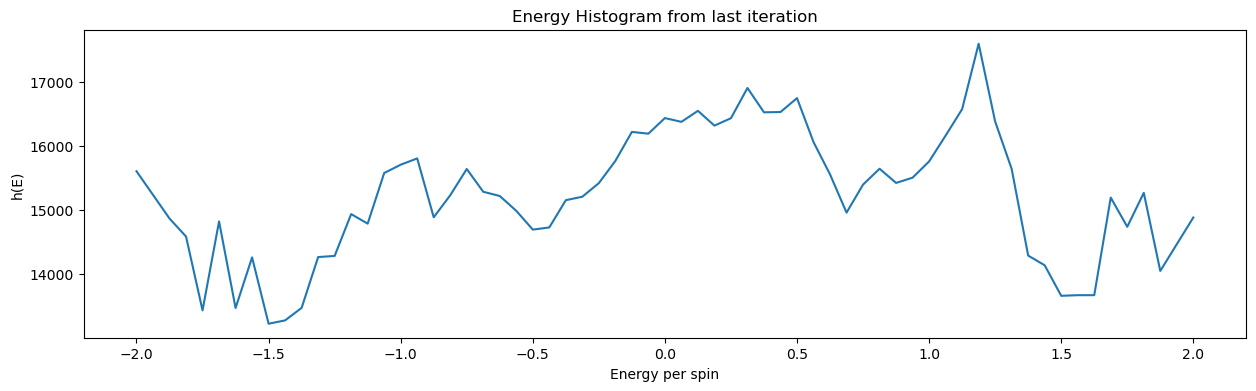

In [ ]:
lngE_list_norm = lngE_list - lngE_list[0]+np.log(2)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(E_list_gen(L)/L**2,lngE_list_norm)
ax.set_xlabel('Energy per spin')
ax.set_ylabel('log(Density of States)')
plt.title(f'Density of States for 2D Ising Model (L={L})')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(E_list_gen(L)/L**2,hE_list)
ax.set_xlabel("Energy per spin")
ax.set_ylabel("h(E)")
plt.title(f'Energy Histogram from last iteration')

plt.show()

## Alternative class definition

In [ ]:
def plot_dos_prob_e(model, temperatures):
    fig,ax = plt.subplots(1,2, figsize=(12, 5))
    
    e_range = model.energy_range/(2*model.L**2)

    ax[0].plot(e_range, model.dos)
    ax[0].set_xlabel('Energy per spin')
    ax[0].set_ylabel('log(Density of States)')
    ax[0].set_title(f'Density of States for 2D Ising Model (L={model.L})')

    for t in temperatures:
        prob_energy = model.calculate_prob_energy(t)
        ax[1].plot(e_range, prob_energy)
    ax[1].set_xlabel('Energy per spin')
    ax[1].set_ylabel('Prob(Energy)')
    ax[1].set_title(f'Energy Distribtuion for 2D Ising Model (L={model.L})')

    plt.show()

In [ ]:
class Wang_Landau_2DIsing:
    # Code works only for H =0 
    def __init__(self, L, J=1):
        self.L = L
        self.J = J
        self.lattice = np.random.choice([-1, 1], size=(L, L))
        self.energy_range = self.E_list_gen()
        self.mag_range = np.arange(-L**2,L**2+1,2)
        #self.dos = np.zeros_like(self.energy_range, dtype=float)
        self.dos = np.zeros((L**2-1,L**2+1), dtype=float)
        self.histogram = np.zeros_like(self.dos, dtype=int)
        self.logf = 1
        self.total_energy = self.calculate_energy()
        self.total_mag = np.sum(self.lattice)
    
    def E_list_gen(self):
        ''' Generates list of energies for even L '''
        if self.L % 2 != 0:
            raise ValueError("This list generation only works for even side lengths")

        E_list=[-2*self.L**2 + 4*k for k in range(0,self.L**2+1)]
        E_list.pop(1)
        E_list.pop(-2)
        E_list=np.array(E_list)  # number of energy states = N-1

        return E_list
        
    def calculate_energy(self):
        energy = 0
        for i in range(self.L):
            for j in range(self.L):
                energy += -self.J * self.lattice[i, j] * (
                    self.lattice[(i+1)%self.L, j] + 
                    self.lattice[i, (j+1)%self.L] )
        return energy
    
    def flip_spin(self):
        i, j = np.random.randint(0, self.L, 2)
        delta_E = 2 * self.J * self.lattice[i, j] * (
            self.lattice[(i+1)%self.L, j] + 
            self.lattice[(i-1)%self.L, j] + 
            self.lattice[i, (j+1)%self.L] + 
            self.lattice[i, (j-1)%self.L] )
        return i, j, delta_E
    
    def calculate_prob_energy(self, T=1):
        partition_function = np.sum([ np.exp(g-e/T) for g,e in zip(self.dos, self.energy_range) ])
        return [ 1/partition_function*np.exp(g-e/T) for g,e in zip(self.dos, self.energy_range) ]


    def run_zero_h(self, logf_min = 1e-8, flatness_criterion = .8, N_sweeps = 1e2):
        # Surprsingly, checking every iteration is faster for L=8, haven't checked other sizes...
        self.dos = np.zeros_like(self.energy_range, dtype=float)
        self.histogram = np.zeros_like(self.energy_range, dtype=int)
        
        index1 = np.argwhere( self.energy_range == self.total_energy)[0,0]
        while self.logf > logf_min:
            iteration = 0
            self.histogram.fill(0)
            while np.min(self.histogram) <= flatness_criterion * np.mean(self.histogram):
                for s in range(int(N_sweeps*self.L**2)):
                    i, j, delta_E = self.flip_spin()
                    new_energy = self.total_energy + delta_E
                    index2 = np.argwhere( self.energy_range == new_energy)[0,0]

                    if (np.random.random() < np.exp(self.dos[index1] - self.dos[index2])):
                        self.lattice[i, j] *= -1
                        self.total_energy = new_energy
                        index1 = index2
                    else:
                        index1 = index1

                    self.dos[index1] += self.logf
                    self.histogram[index1] += 1
                    iteration += 1
                
            #print(f"ln(f) = {self.logf}", "and sweeps = ", iteration//self.L**2)
            self.logf *= 1/2
        
        #self.dos -= self.dos.min()
        self.dos -= (self.dos[0]-np.log(2))
        return self.energy_range, self.dos

Computation time =  22.071726083755493


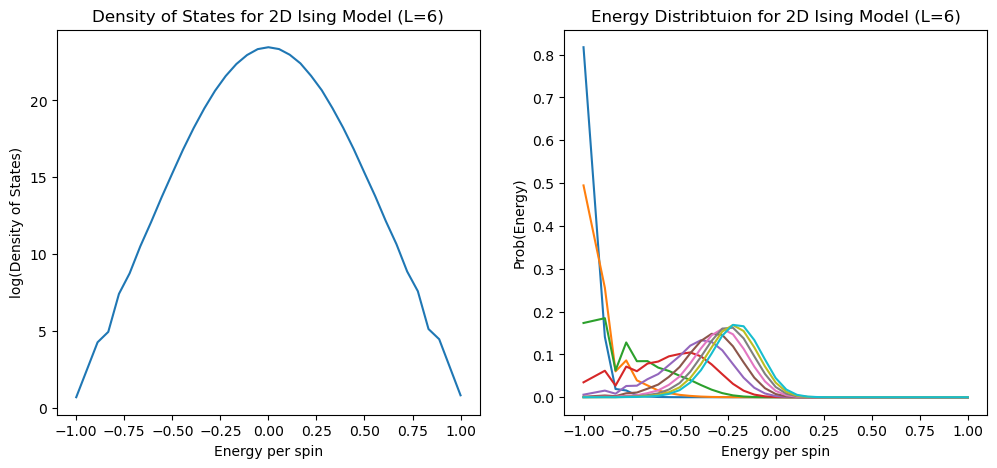

In [ ]:
# Run the simulation
L = 6
model = Wang_Landau_2DIsing(L)
t0 = time()
energy_range, dos = model.run_zero_h()
print("Computation time = ", time()-t0)

temperatures = np.linspace(1.5,5,10)
plot_dos_prob_e(model,temperatures)